In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
import h5py
import os
import cv2
from sklearn.decomposition import PCA
from pathlib import Path
import scipy.signal as ss
import scipy.ndimage as sn
from astropy.io import fits
from kink import detect_kinks
import pickle
from sklearn.linear_model import LinearRegression


In [2]:
lams = ['193','171','304','1600','131','94']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']

flare_catalog = pd.read_csv('aia_flares_catalog_verified.csv')
# convert all time columns to datetimes
flare_catalog['goes_start_time'] = pd.to_datetime(flare_catalog['goes_start_time'])
flare_catalog['goes_end_time'] = pd.to_datetime(flare_catalog['goes_end_time'])

for j in range(len(lams)):
    lam = lams[j]
    flare_catalog[lam+'_start_time'] = pd.to_datetime(flare_catalog[lam+'_start_time'])
    flare_catalog[lam+'_peak_time'] = pd.to_datetime(flare_catalog[lam+'_peak_time'])
    flare_catalog[lam+'_end_time'] = pd.to_datetime(flare_catalog[lam+'_end_time'])

flare_catalog['aia_max_start_time']  = flare_catalog[[lam+'_start_time'for lam in lams]].max(axis=1)
flare_catalog['aia_min_end_time']  = flare_catalog[[lam+'_end_time'for lam in lams]].min(axis=1)
flare_catalog['aia_min_start_time']  = flare_catalog[[lam+'_start_time'for lam in lams]].min(axis=1)
flare_catalog['aia_max_end_time']  = flare_catalog[[lam+'_end_time'for lam in lams]].max(axis=1)

limbdata = pd.read_csv('sharps_limbs_data.csv')
limbdata['Start Time'] = pd.to_datetime(limbdata['Start Time'])
limbdata['End Time'] = pd.to_datetime(limbdata['End Time'])
flare_catalog = flare_catalog.merge(limbdata,how='left',on='SHARP')

flarewithlimbs = flare_catalog[np.logical_or(flare_catalog['aia_max_end_time']<flare_catalog['Start Time'],flare_catalog['aia_min_start_time']>flare_catalog['End Time'])]
print('Total flares on the limb:',len(flarewithlimbs))
print('C:',np.sum(flarewithlimbs['ert_pred_CMX']=='C'))
print('M:',np.sum(flarewithlimbs['ert_pred_CMX']=='M'))
print('X:',np.sum(flarewithlimbs['ert_pred_CMX']=='X'))

flare_catalog_goes = flare_catalog[flare_catalog['goes_flare_ind'].notnull()]
flare_catalog_nogoes = flare_catalog[flare_catalog['goes_flare_ind'].isnull()]
print('Flare catalog GOES, no GOES:',len(flare_catalog_goes),len(flare_catalog_nogoes))

flare_catalog = flare_catalog[np.logical_and(flare_catalog['aia_max_end_time']>=flare_catalog['Start Time'],flare_catalog['aia_min_start_time']<=flare_catalog['End Time'])]
flare_catalog_goes = flare_catalog[flare_catalog['goes_flare_ind'].notnull()]
flare_catalog_nogoes = flare_catalog[flare_catalog['goes_flare_ind'].isnull()]
print('After filtering limb flares, flare catalog GOES, no GOES:',len(flare_catalog_goes),len(flare_catalog_nogoes))

Total flares on the limb: 3556
C: 3384
M: 111
X: 5
Flare catalog GOES, no GOES: 2899 13109
After filtering limb flares, flare catalog GOES, no GOES: 2404 10048


In [3]:
goes_catalog = pd.read_csv('goes_catalog_with_noaa_ar2.csv',na_values=' ')
goes_catalog = goes_catalog.dropna(subset=['SHARP'])
goes_catalog = goes_catalog[pd.to_numeric(goes_catalog['SHARP'])>=20]
goes_catalog.SHARP = pd.to_numeric(goes_catalog['SHARP']).astype('int64')

bhs = pd.read_csv('/home/kiva6588/Code/sharps_badheaders.csv')
bhs = [x[0] for x in bhs.values]
goes_catalog = goes_catalog[~goes_catalog.SHARP.isin(bhs)]

outofrange = pd.read_csv('/home/kiva6588/Code/flares_with_limbs2.csv')
outofrange = [x[0] for x in outofrange.values]
goes_catalog = goes_catalog.drop(outofrange,errors='ignore')

nes_noaa = pd.read_csv('/home/kiva6588/Code/nonempty_sharps_with_noaa_ar.csv')
goes_catalog = goes_catalog[goes_catalog.SHARP.isin(nes_noaa.HARPNUM)]
goes_catalog = goes_catalog.reset_index().rename(columns={'index':'flare_ind'})

print('GOES catalog before new limb filtering:',len(goes_catalog))
print('B:',sum(goes_catalog['CMX']=='B'),'C:',sum(goes_catalog['CMX']=='C'),'M:',sum(goes_catalog['CMX']=='M'),'X:',sum(goes_catalog['CMX']=='X'))

goes_catalog['goes_start_time'] = pd.to_datetime('20' + goes_catalog['DATE'].astype('str') + '_' + 
                                        goes_catalog['START_TIME'].astype('str').str.zfill(4) + '00', format='%Y%m%d_%H%M%S')
goes_catalog['goes_end_time'] = pd.to_datetime('20' + goes_catalog['DATE'].astype('str') + '_' + 
                                        goes_catalog['END_TIME'].astype('str').str.zfill(4) + '00', format='%Y%m%d_%H%M%S')
goes_catalog['goes_end_time'][goes_catalog['goes_end_time']<goes_catalog['goes_start_time']] = goes_catalog['goes_end_time'][goes_catalog['goes_end_time']<goes_catalog['goes_start_time']]+timedelta(days=1)

limbdata['Start Time'] = pd.to_datetime(limbdata['Start Time'])
limbdata['End Time'] = pd.to_datetime(limbdata['End Time'])

goes_catalog = goes_catalog.merge(limbdata,how='inner',on='SHARP')

goes_catalog = goes_catalog[np.logical_and(goes_catalog['goes_end_time']>=goes_catalog['Start Time'],goes_catalog['goes_start_time']<=goes_catalog['End Time'])]

print('GOES catalog after new limb filtering:',len(goes_catalog))
print('B:',sum(goes_catalog['CMX']=='B'),'C:',sum(goes_catalog['CMX']=='C'),'M:',sum(goes_catalog['CMX']=='M'),'X:',sum(goes_catalog['CMX']=='X'))

GOES catalog before new limb filtering: 4959
B: 1807 C: 2825 M: 305 X: 22
GOES catalog after new limb filtering: 3496
B: 968 C: 2269 M: 243 X: 16


Flares detected from AIA and cross-referenced with GOES
B:  279
C:  1870
M:  239
X:  16
>=C5:  541
Flares in GOES but not detected from AIA:
B: 692
C: 408
M: 8
X: 0
>=C5: 54
Flares not in GOES but estimated from ERT using AIA:
C:  9984
M:  62
X:  2
>=C5:  326


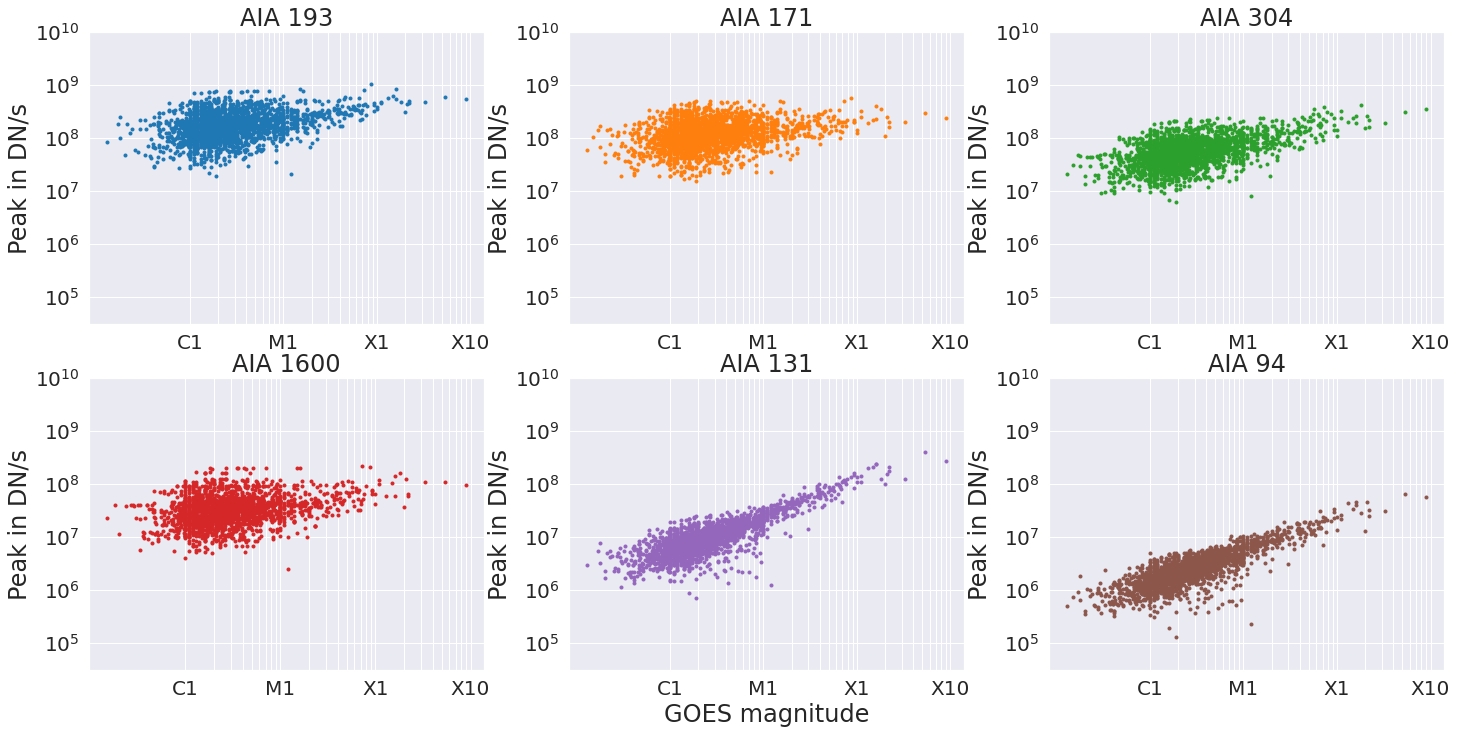

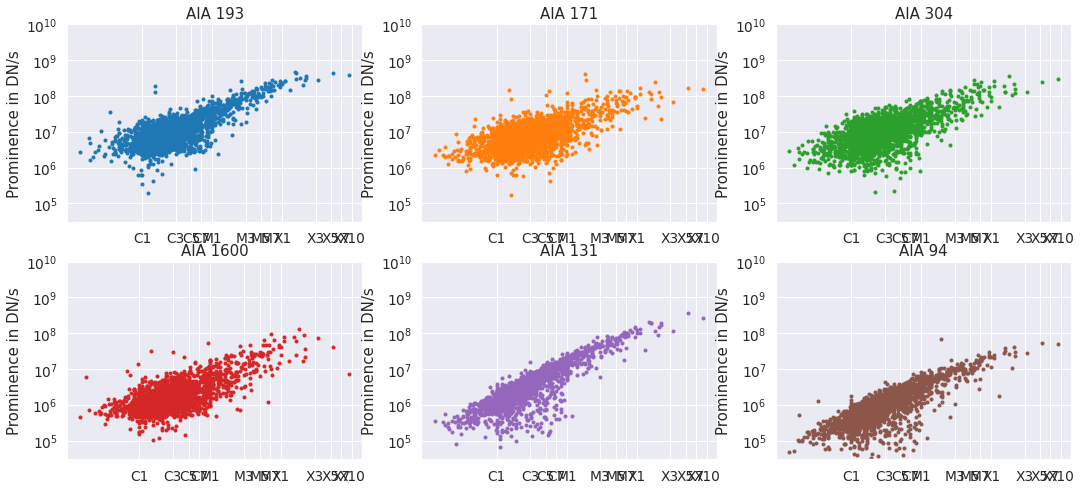

In [23]:
fig2,axs2 = plt.subplots(2,3,figsize=(20,10))
for j in range(len(lams)):
    ax = axs2[j//3,j-j//3*3]
    ax.loglog((flare_catalog_goes['goes_magnitude']),(flare_catalog_goes[lams[j]+'_magnitude']),'.',color=colors[j])
    ax.set_title('AIA '+lams[j],fontsize=24)
    ax.set_ylabel('Peak in DN/s',fontsize=24)
    ax.set_ylim(3e4,1e10)
    ax.grid(True,axis='both')
    plt.setp(ax.get_yticklabels(),fontsize=20)
    ax.set_xticks(ticks=([1e-6,2e-6,3e-6,4e-6,5e-6,6e-6,7e-6,8e-6,9e-6,1e-5,2e-5,3e-5,4e-5,5e-5,6e-5,7e-5,8e-5,9e-5,1e-4,2e-4,3e-4,4e-4,5e-4,6e-4,7e-4,8e-4,9e-4,1e-3]))
    ax.set_xticklabels(labels=['C1','','','','','','','','','M1','','','','','','','','','X1','','','','','','','','','X10'],fontsize=20)
axs2[1,1].set_xlabel('GOES magnitude',fontsize=24)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.grid(True)
plt.tight_layout(pad=0)
plt.savefig('../figures/aiapeaksvsgoespeaks.eps',bbox_inches='tight',pad_inches=0)

fig3,axs3 = plt.subplots(2,3,figsize=(18,8))
for j in range(len(lams)):
    ax = axs3[j//3,j-j//3*3]
    ax.loglog((flare_catalog_goes['goes_magnitude']),(flare_catalog_goes[lams[j]+'_prominence']),'.',color=colors[j])
    ax.set_title('AIA '+lams[j])
    ax.set_ylabel('Prominence in DN/s')
    ax.set_ylim(3e4,1e10)
    ax.grid(True)
    ax.set_xticks(ticks=([1e-6,3e-6,5e-6,7e-6,1e-5,3e-5,5e-5,7e-5,1e-4,3e-4,5e-4,7e-4,1e-3]))
    ax.set_xticklabels(labels=['C1','C3','C5','C7','M1','M3','M5','M7','X1','X3','X5','X7','X10'])
print('Flares detected from AIA and cross-referenced with GOES')
print('B: ',len(flare_catalog_goes[flare_catalog_goes['CMX']=='B']))
print('C: ',len(flare_catalog_goes[flare_catalog_goes['CMX']=='C']))
print('M: ',len(flare_catalog_goes[flare_catalog_goes['CMX']=='M']))
print('X: ',len(flare_catalog_goes[flare_catalog_goes['CMX']=='X']))
print('>=C5: ',len(flare_catalog_goes[flare_catalog_goes['goes_magnitude']>=5e-6]))
print('Flares in GOES but not detected from AIA:')
print('B:',len(goes_catalog[np.logical_and(goes_catalog['CMX']=='B',~goes_catalog['flare_ind'].isin(flare_catalog_goes['goes_flare_ind']))]))
print('C:',len(goes_catalog[np.logical_and(goes_catalog['CMX']=='C',~goes_catalog['flare_ind'].isin(flare_catalog_goes['goes_flare_ind']))]))
print('M:',len(goes_catalog[np.logical_and(goes_catalog['CMX']=='M',~goes_catalog['flare_ind'].isin(flare_catalog_goes['goes_flare_ind']))]))
print('X:',len(goes_catalog[np.logical_and(goes_catalog['CMX']=='X',~goes_catalog['flare_ind'].isin(flare_catalog_goes['goes_flare_ind']))]))
print('>=C5:',len(goes_catalog[np.logical_and(goes_catalog['INTENSITY']/10>=5e-6,~goes_catalog['flare_ind'].isin(flare_catalog_goes['goes_flare_ind']))]))
print('Flares not in GOES but estimated from ERT using AIA:')
print('C: ',len(flare_catalog_nogoes[flare_catalog_nogoes['ert_pred_CMX']=='C']))
print('M: ',len(flare_catalog_nogoes[flare_catalog_nogoes['ert_pred_CMX']=='M']))
print('X: ',len(flare_catalog_nogoes[flare_catalog_nogoes['ert_pred_CMX']=='X']))
print('>=C5: ',len(flare_catalog_nogoes[flare_catalog_nogoes['ert_pred_intensity']>=5e-6]))

Flares detected in AIA but not in GOES:
Total: 10048
~>=M1 (peak >=1.5e7 in 131 and >=4e6 in 94): 554
~>=M5 (peak >=5e7 in 131 and >=1e7 in 94): 18


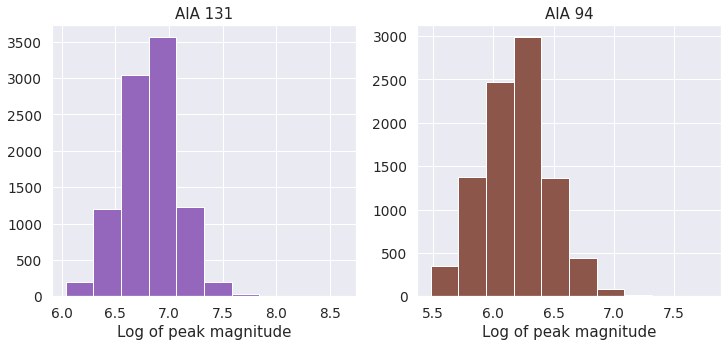

In [99]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].hist(np.log10(flare_catalog_nogoes['131_magnitude']),color=colors[-2])
ax[0].set_title('AIA 131')
ax[0].set_xlabel('Log of peak magnitude')
ax[1].hist(np.log10(flare_catalog_nogoes['94_magnitude']),color=colors[-1])
ax[1].set_title('AIA 94')
ax[1].set_xlabel('Log of peak magnitude')
print('Flares detected in AIA but not in GOES:')
print('Total:',len(flare_catalog_nogoes))
print('~>=M1 (peak >=1.5e7 in 131 and >=4e6 in 94):',np.sum(np.logical_and(flare_catalog_nogoes['131_magnitude']>=1.5e7,flare_catalog_nogoes['94_magnitude']>=4e6)))
print('~>=M5 (peak >=5e7 in 131 and >=1e7 in 94):',np.sum(np.logical_and(flare_catalog_nogoes['131_magnitude']>=5e7,flare_catalog_nogoes['94_magnitude']>=1e7)))

In [129]:
missing_X = goes_catalog[np.logical_and(goes_catalog['CMX']=='X',~goes_catalog['flare_ind'].isin(flare_catalog_goes['goes_flare_ind']))]
print(missing_X)

Empty DataFrame
Columns: [flare_ind, DATE, START_TIME, END_TIME, MAX_TIME, LOCATION, CMX, CMX_VALUE, INTENSITY, FLUX, AR, SHARP, goes_start_time, goes_end_time, Start Time, End Time, Notes]
Index: []


% L2 error:  5.499724120818906
% L1 error:  4.099517788246572
% L2 error on MX flares only:  12.478192184308183
% L1 error on MX flares only:  9.802877297554483
% L2 error:  6.051555960212948
% L1 error:  4.637226880507909
% L2 error on MX flares only:  13.686239735562705
% L1 error on MX flares only:  11.296863375249956


Text(0.5, 1.0, 'Predicted vs True (log of intensity) based on AIA 131 peak prominence')

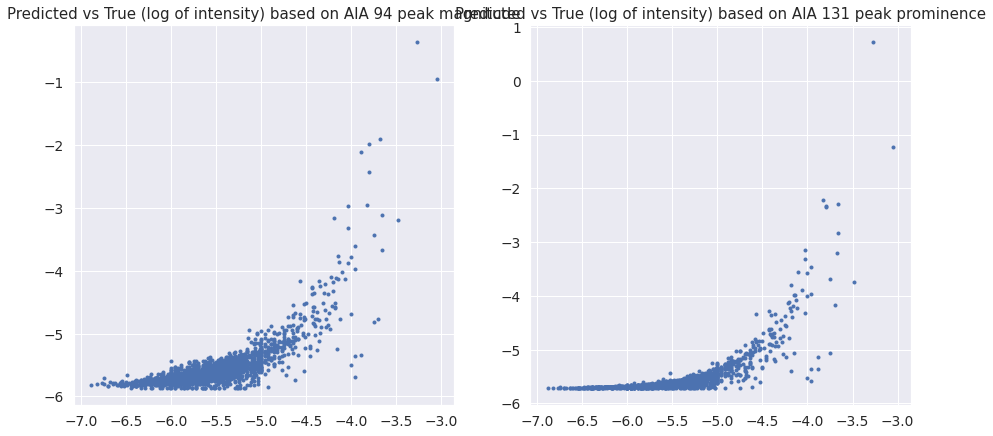

In [76]:
regressor = LinearRegression(fit_intercept = True,normalize=False)
y_true = np.log10(flare_catalog_goes['goes_magnitude'])
x = np.array(flare_catalog_goes['94_magnitude'].replace([np.nan],0)).reshape(-1,1)
regressor.fit(x,np.array(y_true))
y_pred = regressor.predict(x)

print('% L2 error: ', np.sqrt(np.sum((y_pred-y_true)**2)/np.sum(y_true**2))*100)
print('% L1 error: ', np.sum(np.abs(y_pred-y_true))/np.sum(np.abs(y_true))*100)
print('% L2 error on MX flares only: ', np.sqrt(np.sum((y_pred[y_true>=-5]-y_true[y_true>=-5])**2)/np.sum(y_true[y_true>=-5]**2))*100)
print('% L1 error on MX flares only: ', np.sum(np.abs(y_pred[y_true>=-5]-y_true[y_true>=-5]))/np.sum(np.abs(y_true[y_true>=-5]))*100)

regressor2 = LinearRegression(fit_intercept = True,normalize=False)
y_true = np.log10(flare_catalog_goes['goes_magnitude'])
x_2 = np.array(flare_catalog_goes['131_prominence'].replace([np.nan],0)).reshape(-1,1)
regressor2.fit(x_2,np.array(y_true))
y_pred_2 = regressor2.predict(x_2)

print('% L2 error: ', np.sqrt(np.sum((y_pred_2-y_true)**2)/np.sum(y_true**2))*100)
print('% L1 error: ', np.sum(np.abs(y_pred_2-y_true))/np.sum(np.abs(y_true))*100)
print('% L2 error on MX flares only: ', np.sqrt(np.sum((y_pred_2[y_true>=-5]-y_true[y_true>=-5])**2)/np.sum(y_true[y_true>=-5]**2))*100)
print('% L1 error on MX flares only: ', np.sum(np.abs(y_pred_2[y_true>=-5]-y_true[y_true>=-5]))/np.sum(np.abs(y_true[y_true>=-5]))*100)


fig,ax = plt.subplots(1,2,figsize=(15,7))
ax[0].plot(y_true,y_pred,'.')
ax[0].set_title('Predicted vs True (log of intensity) based on AIA 94 peak magnitude')
ax[1].plot(y_true,y_pred_2,'.')
ax[1].set_title('Predicted vs True (log of intensity) based on AIA 131 peak prominence')

In [25]:
flares_MX = flare_catalog_goes[flare_catalog_goes['goes_magnitude']>=1e-5]
print(flares_MX[flares_MX.duplicated(keep=False,subset=['goes_flare_ind'])])
print(len(flares_MX))

Empty DataFrame
Columns: [SHARP, goes_flare_ind, CMX, CMX_VALUE, goes_magnitude, goes_start_time, goes_end_time, 193_peak_time, 193_start_time, 193_end_time, 193_magnitude, 193_prominence, 171_peak_time, 171_start_time, 171_end_time, 171_magnitude, 171_prominence, 304_peak_time, 304_start_time, 304_end_time, 304_magnitude, 304_prominence, 1600_peak_time, 1600_start_time, 1600_end_time, 1600_magnitude, 1600_prominence, 131_peak_time, 131_start_time, 131_end_time, 131_magnitude, 131_prominence, 94_peak_time, 94_start_time, 94_end_time, 94_magnitude, 94_prominence, aia_max_start_time, aia_mean_peak_time, aia_min_end_time, 193_est_size, 193_sum_intensity, 171_est_size, 171_sum_intensity, 304_est_size, 304_sum_intensity, 1600_est_size, 1600_sum_intensity, 131_est_size, 131_sum_intensity, 94_est_size, 94_sum_intensity, Nx, Ny, LAT_FWT, LON_FWT, AREA_ACR, USFLUXL, MEANGAM, MEANGBT, MEANGBZ, MEANGBH, MEANJZD, TOTUSJZ, MEANALP, MEANJZH, ABSNJZH, SAVNCPP, MEANPOT, TOTPOT, MEANSHR, SHRGT45, R_VAL

In [26]:

starts = np.zeros((len(flares_MX),len(lams)))
ends = np.zeros((len(flares_MX),len(lams)))
peaks = np.zeros((len(flares_MX),len(lams)))

# convert all time columns to datetimes
# flares_MX['aia_max_start_time'] = pd.to_datetime(flares_MX['aia_max_start_time'])
# flares_MX['aia_min_end_time'] = pd.to_datetime(flares_MX['aia_min_end_time'])
flares_MX['goes_start_time'] = pd.to_datetime(flares_MX['goes_start_time'])
flares_MX['goes_end_time'] = pd.to_datetime(flares_MX['goes_end_time'])

for j in range(len(lams)):
    lam = lams[j]
    flares_MX[lam+'_start_time'] = pd.to_datetime(flares_MX[lam+'_start_time'])
    flares_MX[lam+'_peak_time'] = pd.to_datetime(flares_MX[lam+'_peak_time'])
    flares_MX[lam+'_end_time'] = pd.to_datetime(flares_MX[lam+'_end_time'])
    flares_MX[lam+'_starts'] = flares_MX[lam+'_start_time'].subtract(flares_MX['goes_start_time']).dt.total_seconds()/60
    flares_MX[lam+'_peaks'] = flares_MX[lam+'_peak_time'].subtract(flares_MX[lam+'_start_time']).dt.total_seconds()/60
    flares_MX[lam+'_ends'] = flares_MX[lam+'_end_time'].subtract(flares_MX[lam+'_start_time']).dt.total_seconds()/60
    starts[:,j] = flares_MX[lam+'_starts']
    peaks[:,j] = flares_MX[lam+'_peaks']
    ends[:,j] = flares_MX[lam+'_ends']
    print('Mean+/-std,median start time diff for AIA ', lam, ': ',flares_MX[lam+'_starts'].mean(), '+/-',flares_MX[lam+'_starts'].std(),',',flares_MX[lam+'_starts'].median())
    print('Mean+/-std,median peak time diff for AIA ', lam, ': ',flares_MX[lam+'_peaks'].mean(), '+/-',flares_MX[lam+'_peaks'].std(),',',flares_MX[lam+'_peaks'].median())

flares_MX['aia_max_start_time']  = flares_MX[[lam+'_start_time'for lam in lams]].max(axis=1)
flares_MX['aia_min_start_time']  = flares_MX[[lam+'_end_time'for lam in lams]].min(axis=1)

print(flares_MX[flares_MX['94_peaks']>60])


Mean+/-std,median start time diff for AIA  193 :  2.4133858267716537 +/- 12.205032735064172 , 0.0
Mean+/-std,median peak time diff for AIA  193 :  14.216535433070867 +/- 15.70291009901639 , 9.0
Mean+/-std,median start time diff for AIA  171 :  2.7176470588235295 +/- 14.778904761109132 , 0.0
Mean+/-std,median peak time diff for AIA  171 :  13.60392156862745 +/- 15.85875104037999 , 7.0
Mean+/-std,median start time diff for AIA  304 :  -0.28627450980392155 +/- 10.061641113300137 , -1.0000000000000002
Mean+/-std,median peak time diff for AIA  304 :  13.611764705882353 +/- 15.005322507912517 , 8.000000000000002
Mean+/-std,median start time diff for AIA  1600 :  0.4039215686274511 +/- 11.692819668704718 , -1.0000000000000002
Mean+/-std,median peak time diff for AIA  1600 :  10.074509803921568 +/- 13.286305825735843 , 6.0
Mean+/-std,median start time diff for AIA  131 :  2.173228346456693 +/- 9.89957038888106 , 0.0
Mean+/-std,median peak time diff for AIA  131 :  13.65748031496063 +/- 10.4871

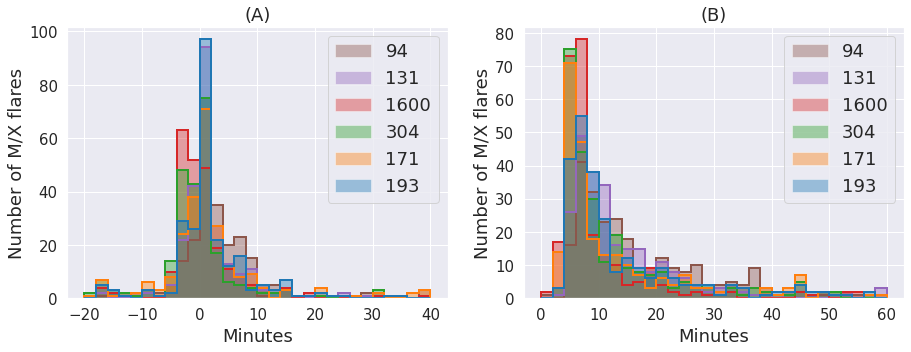

In [37]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

# plt.title('Time from GOES start to AIA start',fontsize=14)
ax[0].set_xlabel('Minutes',fontsize=18)
ax[0].set_ylabel('Number of M/X flares',fontsize=18)
ax[0].set_title('(A)',fontsize=18)
# axs2[2].set_title('Difference between AIA end time and AIA start time')
# axs2[2].set_xlabel('Minutes')
# axs2[2].set_ylabel('Probability')
ax[0].hist((starts[~np.isnan(starts)[:,0],0],starts[~np.isnan(starts)[:,1],1],starts[~np.isnan(starts)[:,2],2],starts[~np.isnan(starts)[:,3],3],starts[~np.isnan(starts)[:,4],4],starts[~np.isnan(starts)[:,5],5]),range=(-20,40),bins=30,density=False,histtype='stepfilled',alpha=0.4,color=colors)
ax[0].hist((starts[~np.isnan(starts)[:,0],0],starts[~np.isnan(starts)[:,1],1],starts[~np.isnan(starts)[:,2],2],starts[~np.isnan(starts)[:,3],3],starts[~np.isnan(starts)[:,4],4],starts[~np.isnan(starts)[:,5],5]),range=(-20,40),bins=30,density=False,histtype='step',alpha=1,linewidth=2,color=colors)
ax[0].legend(lams[::-1],fontsize=18)
plt.setp(ax[0].get_yticklabels(),fontsize=15)
plt.setp(ax[0].get_xticklabels(),fontsize=15)

# fig2 = plt.figure(figsize=(7,5))
# plt.title('Time from AIA start to AIA peak',fontsize=14)
ax[1].set_xlabel('Minutes',fontsize=18)
ax[1].set_ylabel('Number of M/X flares',fontsize=18)
ax[1].set_title('(B)',fontsize=18)
ax[1].hist((peaks[~np.isnan(peaks)[:,0],0],peaks[~np.isnan(peaks)[:,1],1],peaks[~np.isnan(peaks)[:,2],2],peaks[~np.isnan(peaks)[:,3],3],peaks[~np.isnan(peaks)[:,4],4],peaks[~np.isnan(peaks)[:,5],5]),range=(0,60),bins=30,density=False,histtype='stepfilled',alpha=0.4,color=colors)
ax[1].hist((peaks[~np.isnan(peaks)[:,0],0],peaks[~np.isnan(peaks)[:,1],1],peaks[~np.isnan(peaks)[:,2],2],peaks[~np.isnan(peaks)[:,3],3],peaks[~np.isnan(peaks)[:,4],4],peaks[~np.isnan(peaks)[:,5],5]),range=(0,60),bins=30,density=False,histtype='step',alpha=1,linewidth=2,color=colors)
ax[1].legend(lams[::-1],fontsize=18)
plt.setp(ax[1].get_yticklabels(),fontsize=15)
plt.setp(ax[1].get_xticklabels(),fontsize=15);

# plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#             hspace = 0, wspace = 0)
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.grid(True)
# plt.tight_layout(pad=1)
plt.savefig('../figures/aiavsgoes_times_histogram.jpg',dpi=600,bbox_inches='tight')
# axs2[2].hist((ends[~np.isnan(ends)[:,0],0],ends[~np.isnan(ends)[:,1],1],ends[~np.isnan(ends)[:,2],2],ends[~np.isnan(ends)[:,3],3],ends[~np.isnan(ends)[:,4],4],ends[~np.isnan(ends)[:,5],5]),bins=50,density=True,histtype='stepfilled',alpha=0.5,range=(0,50));

(10, 23)


,seed,RMSE_train,MAE_train,R2_train,L2err_train,RMSE_test,MAE_test,R2_test,L2err_test
0,1001,0.087045,0.062688,0.959797,1.929038,0.146664,0.104865,0.893103,3.716219
1,2001,0.088775,0.062965,0.958938,1.922476,0.152008,0.105394,0.876563,3.166244
2,3001,0.088449,0.063337,0.958577,1.881347,0.143727,0.104482,0.896514,2.991111
3,4001,0.086574,0.062103,0.961283,1.820625,0.147714,0.105881,0.879234,3.452075
4,5001,0.087287,0.062793,0.960044,1.880786,0.151241,0.104244,0.881034,3.162590
5,6001,0.088512,0.063417,0.959241,1.800589,0.145780,0.103659,0.885920,3.639653
6,7001,0.087826,0.062698,0.959363,1.814006,0.160818,0.111347,0.867940,4.132299
7,8001,0.087304,0.062593,0.959543,1.841561,0.142509,0.097813,0.899217,3.218405
8,9001,0.090010,0.063701,0.957859,1.814187,0.146232,0.102562,0.885113,4.092937
9,10001,0.087007,0.062681,0.960350,1.904433,0.142018,0.101600,0.894577,3.150484


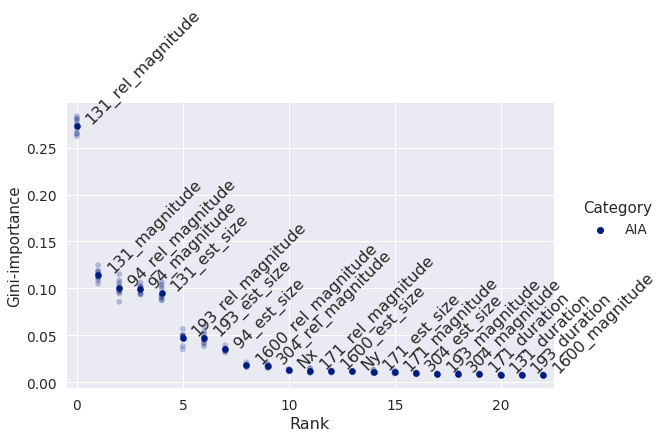

In [48]:
ert_results = pd.read_csv('ert_results_aia/seed10001/ert_results_aia_verified.csv')
ert_metrics = ert_results.iloc[:,:9]
ert_features = ert_results.iloc[:,list(range(9,len(ert_results.columns)))]
mean_features = np.mean(ert_features.iloc[:,:],axis=0)
rank = np.argsort(mean_features)
# print(rank)
ert_features = ert_features.iloc[:,rank[:2:-1]]
# print(len(rank))
print(ert_features.shape)
# replace features with rank
features = ert_features.columns
# ert_features.set_axis(np.arange(len(features)),axis=1,inplace=True)
# print(ert_features)
ert_features_long = ert_features.melt(var_name="Features",value_name="Gini-importance")
# ert_features_long['Rank'] = np.arange(len(ert_features_long))
ert_features_long['Category'] = 0
ert_features_long.loc[ert_features_long.iloc[:,0] =='SIZE','Category'] = 'GOES'
ert_features_long.loc[ert_features_long.iloc[:,0].str.isupper(),'Category']='HMI'
ert_features_long.loc[~ert_features_long.iloc[:,0].str.isupper(),'Category'] = 'AIA'

sns.set(rc={'figure.figsize':(11.7,8.27)},font_scale=1.25)
_categories = ['AIA','HMI']
g = sns.relplot(data=ert_features_long, x='Features', y='Gini-importance',hue='Category',palette='dark',alpha=.25, aspect=1.61)
# sns.move_legend(g,'upper right',bbox_to_anchor=(0.8,0.8))
sns.pointplot(data=ert_features_long,x="Features",y="Gini-importance",hue='Category',palette='dark',join=False,scale=.75,ci=None)
plt.legend([],[],frameon=False)
plt.grid(True,axis='both')
plt.xticks(range(0,len(features)+1,5),range(0,len(features)+1,5))
plt.xlabel('Rank',fontsize=16)
features = pd.DataFrame({'Feature':features,'Rank':range(len(features)),'Gini-importance':mean_features[rank[:2:-1]]})
features.reset_index
for v in features.iterrows():
    plt.text(v[1][1] + 0.3, v[1][2] + 0.003, f'{v[1][0]}', rotation=45, fontsize=16)
plt.savefig('../figures/featureimportances_hmiandaia.jpg',dpi=600,bbox_inches='tight')
ert_metrics


In [46]:
mean_metrics = np.mean(ert_metrics.iloc[:,1:],axis=0)
std_metrics = np.std(ert_metrics.iloc[:,1:],axis=0)
print(mean_metrics)
print(std_metrics)

RMSE_train     0.077096
MAE_train      0.056721
R2_train       0.968831
L2err_train    1.703649
RMSE_test      0.145101
MAE_test       0.102891
R2_test        0.890154
L2err_test     3.398593
dtype: float64
RMSE_train     0.000815
MAE_train      0.000336
R2_train       0.000571
L2err_train    0.051702
RMSE_test      0.005274
MAE_test       0.002931
R2_test        0.009127
L2err_test     0.364848
dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


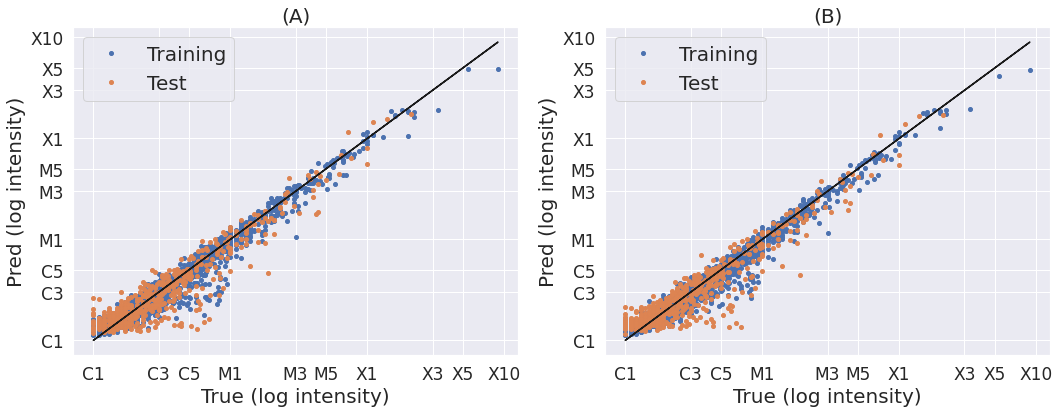

In [58]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
y_train = np.load('ert_results_aia/seed4001/train_true.npy')
y_train_pred = np.load('ert_results_aia/seed4001/train_pred.npy')
y_valid = np.load('ert_results_aia/seed4001/valid_true.npy')
y_valid_pred = np.load('ert_results_aia/seed4001/valid_pred.npy')
ax[0].plot(y_train*3-6,y_train_pred*3-6,'.',markersize=8)
ax[0].plot(y_valid*3-6,y_valid_pred*3-6,'.',markersize=8)
ax[0].plot(y_train*3-6,y_train*3-6,'k')
ax[0].set_xticks(np.log10([1e-6,3e-6,5e-6,1e-5,3e-5,5e-5,1e-4,3e-4,5e-4,1e-3]))
ax[0].set_xticklabels(['C1','C3','C5','M1','M3','M5','X1','X3','X5','X10'],fontsize=17)
ax[0].set_yticks(np.log10([1e-6,3e-6,5e-6,1e-5,3e-5,5e-5,1e-4,3e-4,5e-4,1e-3]))
ax[0].set_yticklabels(['C1','C3','C5','M1','M3','M5','X1','X3','X5','X10'],fontsize=17)
ax[0].set_xlabel('True (log intensity)',fontsize=20)
ax[0].set_ylabel('Pred (log intensity)',fontsize=20)
ax[0].legend(['Training','Test'],fontsize=20)
ax[0].set_title('(A)',fontsize=20)
ax[0].grid(True)

y_train = np.load('ert_results_hmiandaia/seed4001/train_true.npy')
y_train_pred = np.load('ert_results_hmiandaia/seed4001/train_pred.npy')
y_valid = np.load('ert_results_hmiandaia/seed4001/valid_true.npy')
y_valid_pred = np.load('ert_results_hmiandaia/seed4001/valid_pred.npy')
ax[1].plot(y_train*3-6,y_train_pred*3-6,'.',markersize=8)
ax[1].plot(y_valid*3-6,y_valid_pred*3-6,'.',markersize=8)
ax[1].plot(y_train*3-6,y_train*3-6,'k')
ax[1].set_xticks(np.log10([1e-6,3e-6,5e-6,1e-5,3e-5,5e-5,1e-4,3e-4,5e-4,1e-3]))
ax[1].set_xticklabels(['C1','C3','C5','M1','M3','M5','X1','X3','X5','X10'],fontsize=17)
ax[1].set_yticks(np.log10([1e-6,3e-6,5e-6,1e-5,3e-5,5e-5,1e-4,3e-4,5e-4,1e-3]))
ax[1].set_yticklabels(['C1','C3','C5','M1','M3','M5','X1','X3','X5','X10'],fontsize=17)
ax[1].set_xlabel('True (log intensity)',fontsize=20)
ax[1].set_ylabel('Pred (log intensity)',fontsize=20)
ax[1].legend(['Training','Test'],fontsize=20)
ax[1].set_title('(B)',fontsize=20)
ax[1].grid(True)

plt.tight_layout()
plt.savefig('../figures/ert_predvstrue_seed4001.eps',bbox_inches='tight')
